In [1]:
import torch 
import matplotlib.pyplot as plt

from torch.distributions import Normal, MixtureSameFamily, Categorical, Independent
import torch

from rbibm.tasks.cde import MixtureDist
from rbi.models import NeuralSplineFlow, MixtureDiagGaussianModel, SplineAutoregressiveModel
from rbi.defenses import FIMTraceRegularizer, FIMLargestEigenvalueRegularizer
from rbi.loss import NLLLoss

torch.manual_seed(0)

C:\Users\manug\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
task = MixtureDist()
generator = task.get_generator()
train_loader, _, _ = task.get_train_test_val_dataset(1000, 10000, 0)

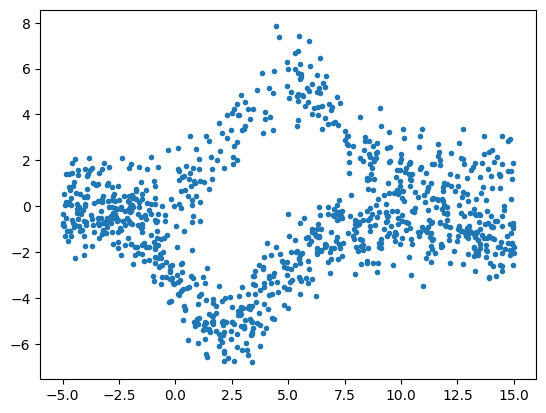

In [3]:
for X, y in train_loader:
    plt.scatter(X,y, marker=".", color="C0")

In [4]:
net = SplineAutoregressiveModel(1,1, bound=20, num_transforms=1, count_bins=20)
loss_fn = NLLLoss(net)

c:\Users\manug\.conda\envs\rbi_camera_ready\lib\site-packages\pyro\nn\auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [5]:
from copy import deepcopy

In [6]:
optim = torch.optim.Adam(net.parameters())
models = []
for i in range(1000):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        optim.step()

    if i < 10:
        models.append(deepcopy(net))
    else:
        if (i % 10) == 0:
            models.append(deepcopy(net))

In [7]:
len(models)

109

In [8]:
torch.manual_seed(3)

In [9]:
net2 = SplineAutoregressiveModel(1,1, bound=15, num_transforms=1, count_bins=20)
loss_fn = NLLLoss(net2)
defense = FIMTraceRegularizer(net2, loss_fn, beta=0.25, algorithm="ema", ema_decay=0.85)
defense.activate()

c:\Users\manug\.conda\envs\rbi_camera_ready\lib\site-packages\pyro\nn\auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [10]:
optim = torch.optim.Adam(net2.parameters())
models_fim = []
for i in range(1000):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        optim.step()

    if i < 10:
        models_fim.append(deepcopy(net2))
    else:
        if (i % 10) == 0:
            models_fim.append(deepcopy(net2))

In [11]:
from rbibm.plots.styles import use_style
from rbi.utils.fisher_info import monte_carlo_fisher


In [12]:


x = torch.linspace(-5,15,500)
y = torch.linspace(-8,8,500)

xx,yy = torch.meshgrid(x,y)
pos = torch.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])

C:\Users\manug\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:

Zs = []
FIMs = []
for net in models:
    Z= net(pos[:,0].unsqueeze(-1)).log_prob(pos[:,1].unsqueeze(-1)).detach().exp()
    F_x1 = monte_carlo_fisher(net,x.reshape(-1,1), mc_samples=1000, create_graph=False, typ="trace")
    FIMs.append(F_x1)
    Zs.append(Z)

# plt.contourf(xx,yy, Z.reshape(xx.shape), cmap="viridis", levels=500, vmin=0,vmax=0.6)

In [14]:
net2 = models_fim[18]
x = torch.linspace(-5,15,500)
y = torch.linspace(-8,8,500)

xx,yy = torch.meshgrid(x,y)
pos = torch.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])

Zs_fim = []
FIMs_fim = []
for net2 in models_fim:
    Z= net2(pos[:,0].unsqueeze(-1)).log_prob(pos[:,1].unsqueeze(-1)).detach().exp()
    F_x2 = monte_carlo_fisher(net2,x.reshape(-1,1), mc_samples=1000, create_graph=False, typ="trace")
    FIMs_fim.append(F_x2)
    Zs_fim.append(Z)
#plt.contourf(xx,yy, Z1.reshape(xx.shape), cmap="viridis", levels=500, vmin=0, vmax=0.6)

In [18]:
%matplotlib tk
plt.rcParams['text.usetex'] = True
from matplotlib.animation import FuncAnimation
with use_style("pyloric"):
    fig, axes = plt.subplots(2, 2,figsize=(5.,3.), gridspec_kw={"height_ratios": [0.8, 0.2]})

    
    axes[0,1].set_xlim(-5,15)
    axes[0,1].set_ylim(-8, 8)
    axes[0,0].set_xlim(-5,15)
    axes[0,0].set_ylim(-8, 8)

    
    axes[0,0].set_title("Without regularization",font="Arial")
    axes[0,1].set_title("With regularization",font="Arial")
    axes[0,0].set_xticks([])
    axes[0,1].set_xticks([])
    axes[0,1].set_yticks([])
    axes[0,0].set_ylabel("$\\theta \sim q_\\phi(\\theta|x)$", font="Arial")
    
    axes[0,0].yaxis.set_label_coords(-0.145, 0.6)

    
    for tick in axes[0,0].yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

    for tick in axes[0,0].yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

    
   
    # axes[1,0].set_xlim(-5,15)
    # axes[1,0].set_ylim(-5,275)
    axes[0,0].set_yticks([])
    axes[0,0].spines[['left', 'bottom']].set_visible(False)
    axes[0,1].spines[['left', 'bottom']].set_visible(False)
    #axes[1,0].set_yticks([0,25])
    # axes[1,1].set_xlim(-5,15)
    # axes[1,1].set_ylim(-5,275)
    axes[1, 0].set_ylabel("$\\mathcal{I}_x$", font="Arial")
    #axes[1,1].set_yticks([])
    axes[1, 1].set_xlabel("$x \\sim p(x)$",font="Arial")
    axes[1, 0].set_xlabel("$x \\sim p(x)$",font="Arial")

    fig.tight_layout()

    def update(frame):
        print(frame)
        # Update
        axes[0,0].clear()
        axes[0,1].clear()
        axes[1,0].clear()
        axes[1,1].clear()
        
        axes[0,1].set_xlim(-5,15)
        axes[0,1].set_ylim(-8, 8)
        axes[0,0].set_xlim(-5,15)
        axes[0,0].set_ylim(-8, 8)

        
        axes[0,0].set_title("Without regularization",font="Arial")
        axes[0,1].set_title("With regularization",font="Arial")
        axes[0,0].set_xticks([])
        axes[0,1].set_xticks([])
        axes[0,1].set_yticks([])
        axes[0,0].set_ylabel("$\\theta \sim q_\\phi(\\theta|x)$", font="Arial")
        axes[0,0].yaxis.set_label_coords(-0.145, 0.6)
        cs1 = axes[0,0].contourf(xx,yy, Zs[frame].reshape(xx.shape), cmap="viridis", levels=500, vmin=0.,vmax=0.6)
        for c in cs1.collections:
            c.set_rasterized(True)
        cs2 = axes[0,1].contourf(xx,yy, Zs_fim[frame].reshape(xx.shape), cmap="viridis", levels=500, vmin=0.,vmax=0.6)
        for c in cs2.collections:
            c.set_rasterized(True)
        

    
        ls1 = axes[1,0].plot(x, FIMs[frame].squeeze(), color="#f03b20", )
        ls2 = axes[1,1].plot(x, FIMs_fim[frame].squeeze(), color="#f03b20",)

          # axes[1,0].set_xlim(-5,15)
        # axes[1,0].set_ylim(-5,275)
        axes[0,0].set_yticks([])
        axes[0,0].spines[['left', 'bottom']].set_visible(False)
        axes[0,1].spines[['left', 'bottom']].set_visible(False)
        #axes[1,0].set_yticks([0,25])
        # axes[1,1].set_xlim(-5,15)
        # axes[1,1].set_ylim(-5,275)
        axes[1, 0].set_ylabel("$\\mathcal{I}_x$", font="Arial")
        axes[1,0].yaxis.set_label_coords(-0.145, 0.6)
        #axes[1,1].set_yticks([])
        axes[1, 1].set_xlabel("$x \\sim p(x)$",font="Arial")
        axes[1, 0].set_xlabel("$x \\sim p(x)$",font="Arial")
      
        t = plt.plot([],[])
        return t



    
    ani = FuncAnimation(fig, update, frames=range(0, 109), blit=True, cache_frame_data =True, interval=100, repeat=False)
    ani.save("fig1b.gif", dpi=200, fps=20)
    #plt.show()
    # This gets proper svg text, but mathcal{I} is undefined
    #fig.savefig("fig1b.svg", transparent=True, bbox_inches="tight")
 # This has mathcal{I}, which is put into the other
#fig.savefig("fig1b_nonedit.svg", transparent=True, bbox_inches="tight")


MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


0
0
0
1
2
3
4
